In [3]:
import os
import json
import numpy as np
import pandas as pd

from scipy.stats import norm, rankdata
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count

import matplotlib.pyplot as plt

from utils.mhar_utils import (
    create_mhar_lags,
    fit_mhar_lasso,
    gvd,
    spillover_metrics,
)

In [4]:
OLD_PARQUET_DIR = "../data/endogenous/old_spillover_indexes"
NEW_DATA_DIR    = "../data/endogenous/prices"

## Load realized measures (recalculated)

In [5]:
revar_path          = os.path.join(NEW_DATA_DIR, "revar_daily_recalculated.parquet")
recov_vech_path     = os.path.join(NEW_DATA_DIR, "recov_vech_daily_recalculated.parquet")
recov_pos_vech_path = os.path.join(NEW_DATA_DIR, "recov_pos_vech_daily_recalculated.parquet")
recov_neg_vech_path = os.path.join(NEW_DATA_DIR, "recov_neg_vech_daily_recalculated.parquet")
vech_labels_path    = os.path.join(NEW_DATA_DIR, "recov_vech_labels_recalculated.json")

revar_df          = pd.read_parquet(revar_path)
recov_vech_df     = pd.read_parquet(recov_vech_path)
recov_pos_vech_df = pd.read_parquet(recov_pos_vech_path)
recov_neg_vech_df = pd.read_parquet(recov_neg_vech_path)

In [6]:
with open(vech_labels_path, "r") as f:
    recov_labels = json.load(f)

recov_vech_df   = recov_vech_df[recov_labels]
recov_pos_vech_df = recov_pos_vech_df[recov_labels]
recov_neg_vech_df = recov_neg_vech_df[recov_labels]

print("ReVar shape:", revar_df.shape)
print("ReCov vech shape:", recov_vech_df.shape)
print("ReCov+ vech shape:", recov_pos_vech_df.shape)
print("ReCov- vech shape:", recov_neg_vech_df.shape)

ReVar shape: (1441, 3)
ReCov vech shape: (1441, 6)
ReCov+ vech shape: (1441, 6)
ReCov- vech shape: (1441, 6)


## 2. PIT transforms (same spirit as original code)


In [7]:
def pit_series(x: pd.Series) -> pd.Series:
    """Univariate PIT using empirical CDF + inverse normal."""
    x = x.dropna().values
    cdf_vals = rankdata(x, method="average") / (len(x) + 1)
    cdf_vals = np.clip(cdf_vals, 1e-6, 1 - 1e-6)
    z = norm.ppf(cdf_vals)
    return pd.Series(z)

def pit_frame(df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in df.columns:
        s = df[col].dropna()
        z = pit_series(s)
        # re-align on original date index (NaNs where missing)
        z.index = s.index
        out[col] = z
    out_df = pd.DataFrame(out, index=df.index)
    return out_df

pit_revar          = pit_frame(revar_df)
pit_recov_vech     = pit_frame(recov_vech_df)
pit_recov_pos_vech = pit_frame(recov_pos_vech_df)
pit_recov_neg_vech = pit_frame(recov_neg_vech_df)

In [9]:
pit_revar.to_parquet(os.path.join(NEW_DATA_DIR, "post_pit/pit_revar_recalculated.parquet"))
pit_recov_vech.to_parquet(os.path.join(NEW_DATA_DIR, "post_pit/pit_recov_vech_recalculated.parquet"))
pit_recov_pos_vech.to_parquet(os.path.join(NEW_DATA_DIR, "post_pit/pit_recov_pos_vech_recalculated.parquet"))
pit_recov_neg_vech.to_parquet(os.path.join(NEW_DATA_DIR, "post_pit/pit_recov_neg_vech_recalculated.parquet"))


## 3. Helper: MHAR spillover (static, H=1)


In [10]:
def mhar_spillover_static(pit_df: pd.DataFrame, tag: str):
    """
    Full-sample MHAR spillover calculation on PIT-transformed series.
    Returns:
        theta_norm: (K,K) array, row-normalised GVD
        TSI       : float
    Also saves LaTeX-ready-ish table to ../data/endogenous/prices.
    """
    # 1. Build MHAR lags
    XY = create_mhar_lags(pit_df)
    X  = XY.drop(columns=pit_df.columns).values
    Y  = XY[pit_df.columns].values
    K  = Y.shape[1]

    # 2. Fit LASSO MHAR
    phi1, model = fit_mhar_lasso(X, Y)   # uses same options as original code

    # 3. Residual covariance Σ
    Y_hat = X @ model.coef_.T + model.intercept_
    U     = Y - Y_hat
    Sigma = U.T @ U / U.shape[0]

    # 4. FEVD and spillovers
    _, theta_norm = gvd([np.eye(K), phi1], Sigma)
    TSI, to_, from_, net_ = spillover_metrics(theta_norm)

    # 5. Build table
    spill_mat = theta_norm * 100
    spill_tbl = pd.DataFrame(spill_mat,
                             index=pit_df.columns,
                             columns=pit_df.columns)
    spill_tbl["Directional FROM others"] = from_
    spill_tbl.loc["Directional TO others"] = list(to_) + [to_.sum()]
    spill_tbl.loc["NET Directional"]      = list(net_) + [np.nan]

    # Save as parquet for comparison
    out_spill_path = os.path.join(
        NEW_DATA_DIR, f"spillover_static_{tag}_recalculated.parquet"
    )
    spill_tbl.to_parquet(out_spill_path)

    print(f"[{tag}] static TSI (recalculated) = {TSI:.4f}%")
    print(f"[{tag}] spillover table saved to: {out_spill_path}")
    return theta_norm, TSI, spill_tbl

## 4. Static spillovers: ReVar, ReCov, ReCov⁺, ReCov⁻


In [12]:
theta_revar, TSI_revar, spill_revar = mhar_spillover_static(
    pit_revar, "mhar_revar"
)

theta_recov, TSI_recov, spill_recov = mhar_spillover_static(
    pit_recov_vech, "mhar_recov"
)

theta_recov_pos, TSI_recov_pos, spill_recov_pos = mhar_spillover_static(
    pit_recov_pos_vech, "mhar_recov_pos"
)

theta_recov_neg, TSI_recov_neg, spill_recov_neg = mhar_spillover_static(
    pit_recov_neg_vech, "mhar_recov_neg"
)

[mhar_revar] static TSI (recalculated) = 39.4132%
[mhar_revar] spillover table saved to: ../data/endogenous/prices\spillover_static_mhar_revar_recalculated.parquet
[mhar_recov] static TSI (recalculated) = 65.8492%
[mhar_recov] spillover table saved to: ../data/endogenous/prices\spillover_static_mhar_recov_recalculated.parquet
[mhar_recov_pos] static TSI (recalculated) = 64.6978%
[mhar_recov_pos] spillover table saved to: ../data/endogenous/prices\spillover_static_mhar_recov_pos_recalculated.parquet
[mhar_recov_neg] static TSI (recalculated) = 61.4043%
[mhar_recov_neg] spillover table saved to: ../data/endogenous/prices\spillover_static_mhar_recov_neg_recalculated.parquet


## 5. Rolling spillovers (TSI) – helper


In [15]:
from sklearn.linear_model import MultiTaskLasso
from joblib import Parallel, delayed
from tqdm import tqdm
import os

ROLL_WIN = 365
N_JOBS   = max(cpu_count() - 1, 1)

def rolling_mhar_tsi(pit_df: pd.DataFrame,
                     tag: str,
                     window: int = ROLL_WIN,
                     out_dir: str = "../data/endogenous/prices"):
    """
    Compute a rolling MHAR-based Total Spillover Index (TSI)
    exactly as in the MHAR-ReCov dynamic code.

    Parameters
    ----------
    pit_df : DataFrame
        PIT-transformed series (ReVar or vech(ReCov), already in levels as used by MHAR).
    tag : str
        Short tag for the output filenames, e.g. "mhar_revar_recalculated" or "mhar_recov_recalculated".
    window : int
        Rolling window length (default 365).
    out_dir : str
        Directory where the parquet file is saved.

    Returns
    -------
    tsi_df : DataFrame
        Rolling TSI time series with column 'TSI_recalculated'.
    """

    os.makedirs(out_dir, exist_ok=True)

    # 1) Global alpha* from full sample (via MultiTaskLassoCV)
    XY_full  = create_mhar_lags(pit_df)
    X_full   = XY_full.drop(columns=pit_df.columns).values
    Y_full   = XY_full[pit_df.columns].values

    _, full_model = fit_mhar_lasso(X_full, Y_full)   # MultiTaskLassoCV with FAST/LASSO_OPTS
    alpha_star    = full_model.alpha_
    print(f"[{tag}] global α* = {alpha_star:.3e}")

    K = pit_df.shape[1]

    # 2) Single-window worker (matches onewindow() in your MHAR-ReCov code)
    def one_window(start: int):
        end = start + window
        wdf = pit_df.iloc[start:end]
        XYw = create_mhar_lags(wdf)
        if XYw.empty:
            return None

        Xw = XYw.drop(columns=pit_df.columns).values
        Yw = XYw[pit_df.columns].values

        # Use fixed alpha_star (not CV) – same as your dynamic code
        mdl = MultiTaskLasso(
            alpha=alpha_star,
            max_iter=50_000,
            tol=1e-4
        ).fit(Xw, Yw)

        # Residual covariance
        resid   = Yw - (Xw @ mdl.coef_.T + mdl.intercept_)
        Sigma_w = np.cov(resid.T)

        # Φ1 = Bd + Bw/7 + Bm/30
        Bd, Bw, Bm = np.split(mdl.coef_, 3, axis=1)
        phi1_w = Bd + Bw/7 + Bm/30

        # Row-normalised FEVD using Koop–Pesaran–Shin GVD
        _, theta_norm_w = gvd([np.eye(K), phi1_w], Sigma_w)

        # TSI_t = (1/K) * sum_{i≠j} θ̃_ij * 100
        tsi_w, *_ = spillover_metrics(theta_norm_w)

        # Index by last date of MHAR-lagged window (same as your code)
        return XYw.index[-1], tsi_w

    # 3) Rolling loop
    starts = range(len(pit_df) - window + 1)
    res = Parallel(n_jobs=N_JOBS)(
        delayed(one_window)(s) for s in tqdm(starts, desc=f"Rolling TSI {tag}")
    )
    res = [r for r in res if r is not None]
    dates, tsi_vals = zip(*res)

    tsi_df = pd.DataFrame(
        {"TSI_recalculated": tsi_vals},
        index=pd.to_datetime(dates)
    )

    out_path = os.path.join(out_dir, f"rolling_tsi_{tag}_recalculated.parquet")
    tsi_df.to_parquet(out_path)
    print(f"[{tag}] rolling TSI saved to: {out_path}")

    return tsi_df


## 6. Rolling TSI: ReVar and ReCov


In [16]:
tsi_revar_roll = rolling_mhar_tsi(pit_revar, f"mhar_revar")
tsi_recov_roll = rolling_mhar_tsi(pit_recov_vech, f"mhar_recov")

# (Optionally): ReCov⁺ and ReCov⁻ rolling TSI
tsi_recov_pos_roll = rolling_mhar_tsi(pit_recov_pos_vech, f"mhar_recov_pos")
tsi_recov_neg_roll = rolling_mhar_tsi(pit_recov_neg_vech, f"mhar_recov_neg")


[mhar_revar] global α* = 4.954e-03


Rolling TSI mhar_revar: 100%|██████████| 1077/1077 [00:07<00:00, 140.41it/s]


[mhar_revar] rolling TSI saved to: ../data/endogenous/prices\rolling_tsi_mhar_revar_recalculated.parquet
[mhar_recov] global α* = 6.021e-03


Rolling TSI mhar_recov: 100%|██████████| 1077/1077 [00:05<00:00, 181.33it/s]


[mhar_recov] rolling TSI saved to: ../data/endogenous/prices\rolling_tsi_mhar_recov_recalculated.parquet
[mhar_recov_pos] global α* = 1.314e-02


Rolling TSI mhar_recov_pos: 100%|██████████| 1077/1077 [00:04<00:00, 218.70it/s]


[mhar_recov_pos] rolling TSI saved to: ../data/endogenous/prices\rolling_tsi_mhar_recov_pos_recalculated.parquet
[mhar_recov_neg] global α* = 8.895e-03


Rolling TSI mhar_recov_neg: 100%|██████████| 1077/1077 [00:04<00:00, 255.35it/s]


[mhar_recov_neg] rolling TSI saved to: ../data/endogenous/prices\rolling_tsi_mhar_recov_neg_recalculated.parquet


## 7. Compare with **original** outputs (saved in `old_spillover_indexes/`)


In [22]:
def compare_tsi_series(
    old_path: str,
    new_df: pd.DataFrame,
    col_old: str = "TSI",
    col_new: str = "TSI_recalculated",
    label: str = ""
):
    # Load old series
    old_df = pd.read_parquet(old_path)

    # Make sure we only keep the needed columns and give them fixed names
    left = old_df[[col_old]].rename(columns={col_old: "TSI_old"})
    right = new_df[[col_new]].rename(columns={col_new: "TSI_new"})

    # Align on common dates
    df = left.join(right, how="inner")

    # Differences
    diff = df["TSI_new"] - df["TSI_old"]

    print(f"\n=== {label} ===")
    print(f"Common dates: {len(df)}")
    print(f"Mean abs diff: {diff.abs().mean():.6f}")
    print(f"Max abs diff:  {diff.abs().max():.6f}")
    print(f"Min abs diff:  {diff.min():.6f}")
    print(f"Max abs diff:  {diff.max():.6f}")

    return df, diff

### 7.1 Compare MHAR-ReVar rolling TSI


In [ ]:
# =========================================================
# 1) MHAR-ReVar
# =========================================================
old_tsi_revar_path = os.path.join(
    OLD_PARQUET_DIR, "rolling_tsi_mhar_revar.parquet"
)

tsi_revar_cmp, diff_revar = compare_tsi_series(
    old_tsi_revar_path,
    tsi_revar_roll,                  
    col_old="TSI",
    col_new="TSI_recalculated",         
    label="MHAR-ReVar rolling TSI (original vs recalculated)"
)


=== MHAR-ReVar rolling TSI (original vs recalculated) ===
Common dates: 1077
Mean abs diff: 0.160649
Max abs diff:  0.895615
Min abs diff:  -0.000469
Max abs diff:  0.895615


In [26]:
# =========================================================
# 2) MHAR-ReCov
# =========================================================
old_tsi_recov_path = os.path.join(
    OLD_PARQUET_DIR, "rolling_tsi_mhar_recov.parquet"
)

tsi_recov_cmp, diff_recov = compare_tsi_series(
    old_tsi_recov_path,
    tsi_recov_roll,                     # new MHAR-ReCov TSI DF
    col_old="TSI",
    col_new="TSI_recalculated",         # adjust to your actual column name
    label="MHAR-ReCov rolling TSI (original vs recalculated)"
)


=== MHAR-ReCov rolling TSI (original vs recalculated) ===
Common dates: 1077
Mean abs diff: 0.000258
Max abs diff:  0.001998
Min abs diff:  -0.001853
Max abs diff:  0.001998


In [27]:
# =========================================================
# 3) MHAR-ReCov⁺ (semivariances positive)
# =========================================================
old_tsi_recov_pos_path = os.path.join(
    OLD_PARQUET_DIR, "rolling_tsi_mhar_recov_pos.parquet"
)

tsi_recov_pos_cmp, diff_recov_pos = compare_tsi_series(
    old_tsi_recov_pos_path,
    tsi_recov_pos_roll,                 # new TSI for ReCov+
    col_old="TSI",
    col_new="TSI_recalculated",
    label="MHAR-ReCov⁺ rolling TSI (original vs recalculated)"
)



=== MHAR-ReCov⁺ rolling TSI (original vs recalculated) ===
Common dates: 1077
Mean abs diff: 0.000108
Max abs diff:  0.001186
Min abs diff:  -0.000594
Max abs diff:  0.001186


In [28]:
# =========================================================
# 4) MHAR-ReCov⁻ (semivariances negative)
# =========================================================
old_tsi_recov_neg_path = os.path.join(
    OLD_PARQUET_DIR, "rolling_tsi_mhar_recov_neg.parquet"
)

tsi_recov_neg_cmp, diff_recov_neg = compare_tsi_series(
    old_tsi_recov_neg_path,
    tsi_recov_neg_roll,                 # new TSI for ReCov-
    col_old="TSI",
    col_new="TSI_recalculated",
    label="MHAR-ReCov⁻ rolling TSI (original vs recalculated)"
)


=== MHAR-ReCov⁻ rolling TSI (original vs recalculated) ===
Common dates: 1077
Mean abs diff: 0.000088
Max abs diff:  0.001822
Min abs diff:  -0.001822
Max abs diff:  0.001112


### 7.1 Plot and compare MHAR-ReVar rolling TSI


In [29]:
def plot_tsi_pair(df_pair, title="", ylabel="TSI (%)"):
    """
    df_pair: DataFrame with columns 'TSI_old' and 'TSI_new' and datetime index.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    
    df_pair["TSI_old"].plot(ax=ax, lw=1.2, label="Original TSI")
    df_pair["TSI_new"].plot(ax=ax, lw=1.2, linestyle="--", label="Recalculated TSI")
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=":", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


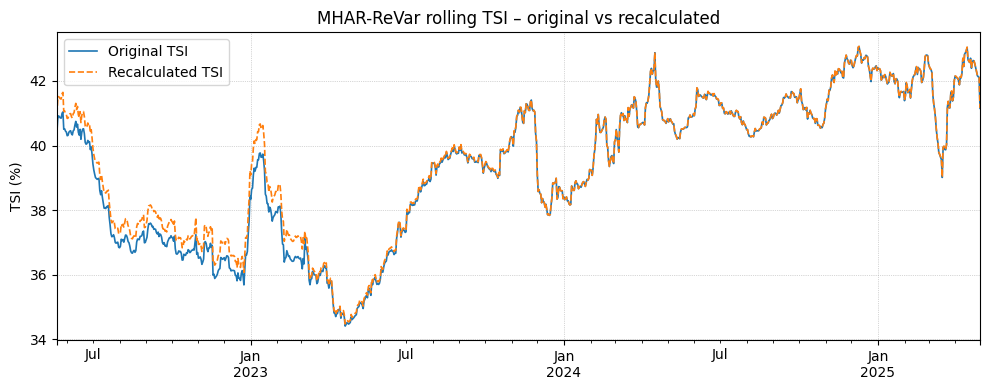

In [30]:
# Example: MHAR-ReVar
plot_tsi_pair(
    tsi_revar_cmp,
    title="MHAR-ReVar rolling TSI – original vs recalculated"
)

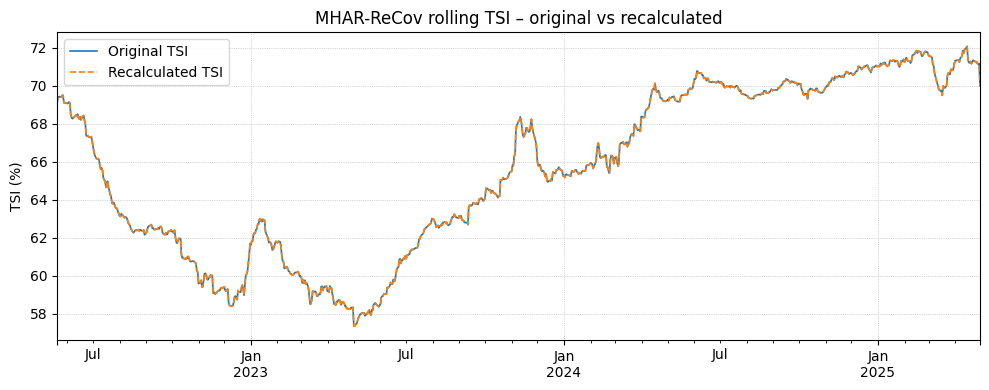

In [31]:
# Example: MHAR-ReCov
plot_tsi_pair(
    tsi_recov_cmp,
    title="MHAR-ReCov rolling TSI – original vs recalculated"
)


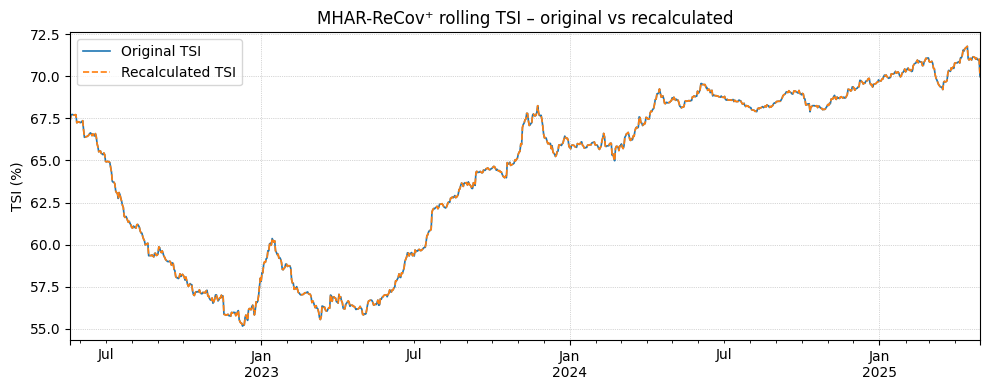

In [32]:
# Example: ReCov+ and ReCov-
plot_tsi_pair(
    tsi_recov_pos_cmp,
    title="MHAR-ReCov⁺ rolling TSI – original vs recalculated"
)

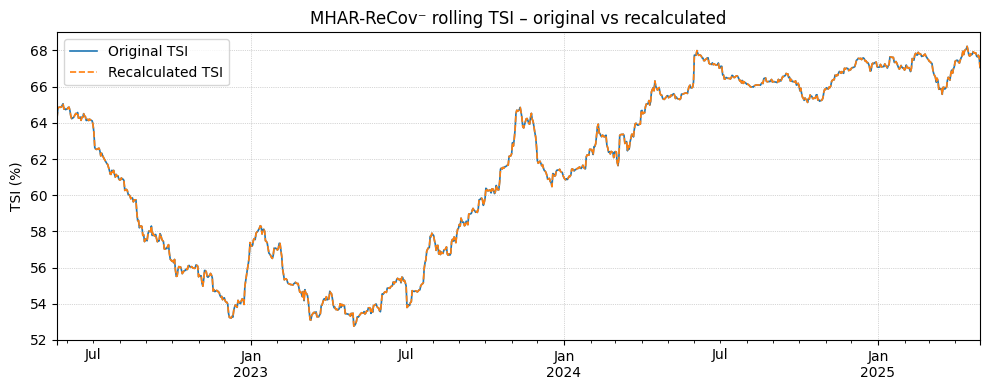

In [33]:
plot_tsi_pair(
    tsi_recov_neg_cmp,
    title="MHAR-ReCov⁻ rolling TSI – original vs recalculated"
)
